## Read the input data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import sys

from utils.utils import read_ogt_data

# SPECIFY THE DESIRED TAXONOMY SPLIT LEVEL HERE!
TAX_LEVEL = "random" # <----------------- taxonomy level for train/test split is here!!
DATA_DIRECTORY = "data_ogt" # <-------- input data directory is here!!

RANDOM_SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
OUTPUT_DIRECTORY = f"../data_ogt/plots_{TAX_LEVEL}_tax_level"

# Read train data
data_filename_train = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/train_data_{TAX_LEVEL}_tax_level"
y_filename_train = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/train_annot_{TAX_LEVEL}_tax_level"
taxa_names_filename_train = None#f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/train_taxa_names_{TAX_LEVEL}_tax_level"
X_train, y_train, X_column_names, taxa_group_names_train = read_ogt_data(data_filename_train, y_filename_train, taxa_names_filename_train, DEVICE)

# Read test data
data_filename_test = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/test_data_{TAX_LEVEL}_tax_level"
y_filename_test = f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/test_annot_{TAX_LEVEL}_tax_level"
taxa_names_filename_test = None#f"../{DATA_DIRECTORY}/input_data/{TAX_LEVEL}/test_taxa_names_{TAX_LEVEL}_tax_level"
X_test, y_test, X_column_names, taxa_group_names_test = read_ogt_data(data_filename_test, y_filename_test, taxa_names_filename_test, DEVICE)

print(f"Number of samples train = {len(X_train)}, number of features = {len(X_column_names)}")
print(f"Number of samples = {len(X_test)}, number of features = {len(X_column_names)}")

Number of samples train = 3002, number of features = 3165
Number of samples = 750, number of features = 3165


In [2]:
#mask = (y_train > 57).flatten()
mask = ((y_train <= 1000) & (y_train > 50)).flatten()
X_train = X_train[mask]
y_train = y_train[mask]


#mask = (y_test > 57).flatten()
mask = ((y_test <= 1000) & (y_test > 50)).flatten()
X_test = X_test[mask]
y_test = y_test[mask]

In [2]:
import torch
import numpy as np

def downsample_histogram_bins(X, y, num_bins=50, max_count=50, seed=42):
    y_np = y.cpu().numpy()
    X_np = X.cpu().numpy()

    # Create histogram
    counts, bin_edges = np.histogram(y_np, bins=num_bins)
    bin_indices = np.digitize(y_np, bin_edges) - 1

    # Collect indices to keep
    selected_indices = []

    rng = np.random.default_rng(seed)

    for bin_idx in range(num_bins):
        idx_in_bin = np.where(bin_indices == bin_idx)[0]
        if len(idx_in_bin) > max_count:
            sampled = rng.choice(idx_in_bin, size=max_count, replace=False)
        else:
            sampled = idx_in_bin
        selected_indices.extend(sampled)

    selected_indices = np.array(selected_indices)

    # Convert back to torch tensors
    X_filtered = torch.tensor(X_np[selected_indices], device=X.device)
    y_filtered = torch.tensor(y_np[selected_indices], device=y.device)

    return X_filtered, y_filtered

# Example usage
X_train, y_train = downsample_histogram_bins(X_train.cpu(), y_train.cpu().squeeze(), num_bins=50, max_count=200)
X_test, y_test = downsample_histogram_bins(X_test.cpu(), y_test.cpu().squeeze(), num_bins=50, max_count=200)


In [2]:
mean_train = np.mean(y_train.cpu().squeeze().numpy())
mean_test = np.mean(y_test.cpu().squeeze().numpy())

print(f"Average OGT of the train set = {mean_train}")
print(f"Average OGT of the train set = {mean_test}")

Average OGT of the train set = 34.29499053955078
Average OGT of the train set = 34.574623107910156


In [4]:
# Downsampling

# Example range
r1, r2 = 20.0, 38.0

# Suppose y_train is a NumPy array
mask_in_range = (y_train.squeeze() >= r1) & (y_train.squeeze() <= r2)
mask_in_range_test = (y_test.squeeze() >= r1) & (y_test.squeeze() <= r2)
print(len(y_train))
mask_out_range = ~mask_in_range
mask_out_range_test = ~mask_in_range_test

# Indices of samples within the range
in_range_indices = np.where(mask_in_range.cpu())[0]
in_range_indices_test = np.where(mask_in_range_test.cpu())[0]

# Set the fraction to keep
keep_fraction = 0.3  # keep 50% of values in the range
num_to_keep = int(keep_fraction * len(in_range_indices))
num_to_keep_test = int(keep_fraction * len(in_range_indices_test))

# Randomly select indices to keep
np.random.seed(42)  # for reproducibility
keep_indices = np.random.choice(in_range_indices, size=num_to_keep, replace=False)
keep_indices_test = np.random.choice(in_range_indices_test, size=num_to_keep_test, replace=False)

# Combine with indices outside the range
final_indices = np.concatenate([keep_indices, np.where(mask_out_range.cpu())[0]])
final_indices_test = np.concatenate([keep_indices_test, np.where(mask_out_range_test.cpu())[0]])

# Downsampled y_train and associated X_train
y_train = y_train[final_indices].cpu()
print(len(y_train))
X_train = X_train[final_indices].cpu()  # if you have corresponding X_train

y_test = y_test[final_indices_test].cpu()
X_test = X_test[final_indices_test].cpu()  # if you have corresponding X_train

2281
1282


823

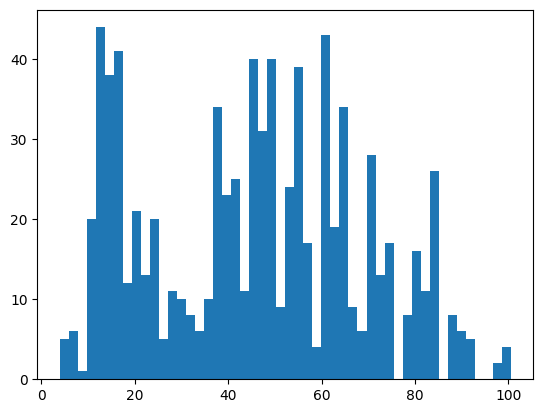

In [5]:
plt.hist(y_train.cpu(), bins = 50)
len(y_train.cpu())

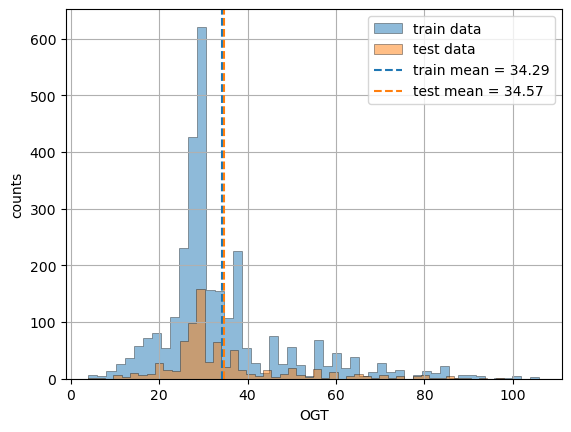

In [3]:
hist = plt.hist(y_train.cpu(), bins = 50, density = False, label = "train data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5, color='tab:blue')
hist = plt.hist(y_test.cpu(), bins = 50, density = False, label = "test data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5, color='tab:orange')
mean_value = y_train.cpu().mean().item()
plt.axvline(mean_value, color='tab:blue', linestyle='--', linewidth=1.5, label=f'train mean = {mean_value:.2f}')
mean_value = y_test.cpu().mean().item()
plt.axvline(mean_value, color='tab:orange', linestyle='--', linewidth=1.5, label=f'test mean = {mean_value:.2f}')


plt.xlabel("OGT")
plt.ylabel("counts")
plt.grid(True)
plt.legend();

## Initial prediction

In [15]:
from utils.utils import train_xgboost, calculate_aver_std
from sklearn.metrics import mean_squared_error,r2_score
from feature_selection.feature_selection_utils import xgboost_train_accur, xgboost_accur_select_features
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05)

# model = XGBRegressor(
#     n_estimators=100,
#     max_depth=5,
#     learning_rate=0.03,
#     reg_alpha=1.0,
#     reg_lambda=1.0
# )

# Define the baseline (for all features) XGBoost accuracy
y_true_cv, y_pred_cv, y_pred_test, model  = train_xgboost(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), weights=None, model=model) 

rmse_test = np.sqrt(mean_squared_error(y_test.cpu(), y_pred_test))
r2_test = r2_score(y_test.cpu(), y_pred_test)

rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2_cv = r2_score(y_true_cv, y_pred_cv)

print(f"XGBoost baseline test RMSE (all features) = {rmse_test:.2f}, R2 = {r2_test:.2f}")
print(f"XGBoost baseline CV RMSE (all features) = {rmse_cv:.2f}, R2 = {r2_cv:.2f}")

XGBoost baseline test RMSE (all features) = 5.89, R2 = 0.83
XGBoost baseline CV RMSE (all features) = 5.84, R2 = 0.85


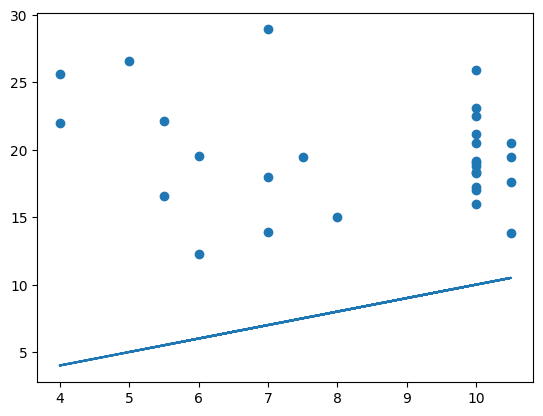

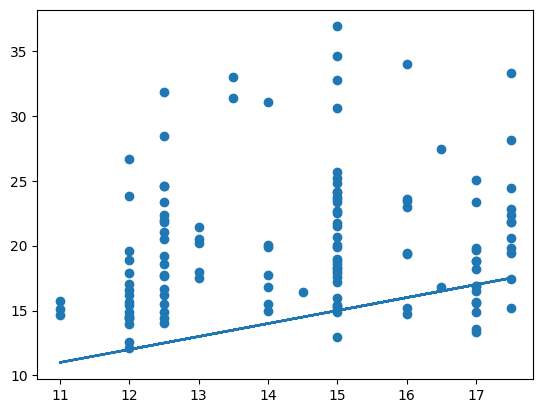

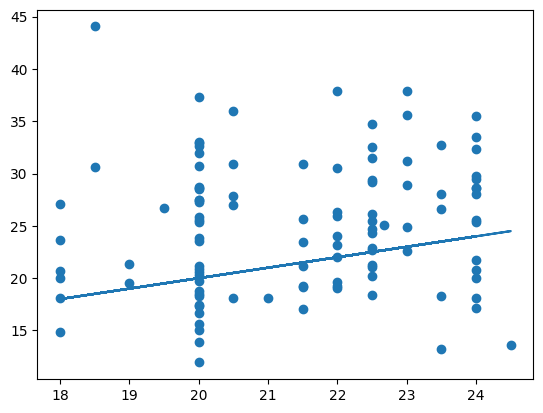

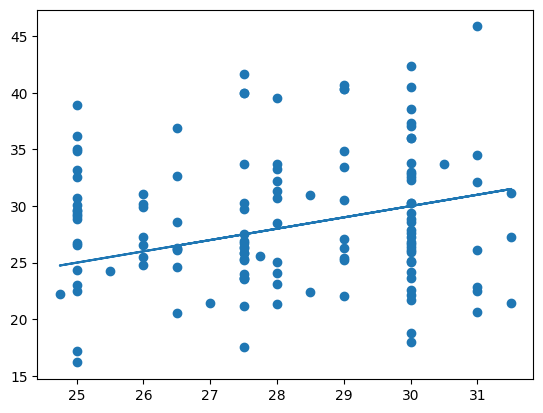

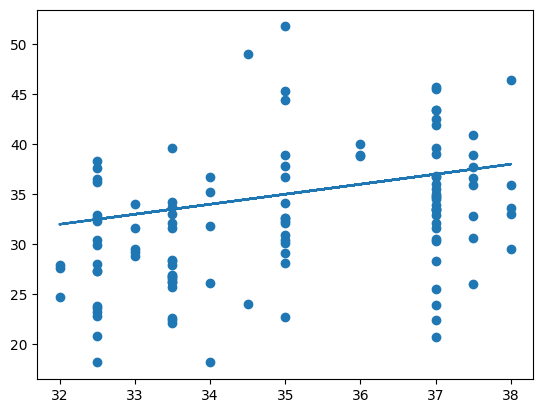

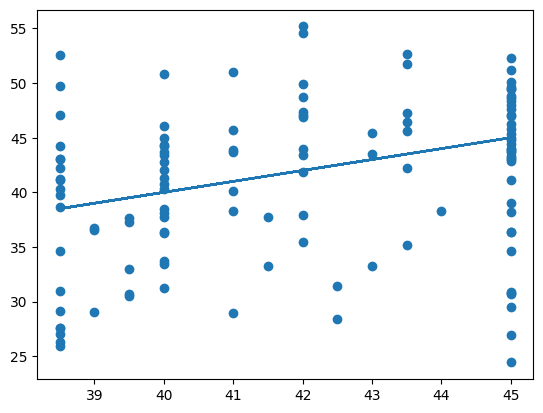

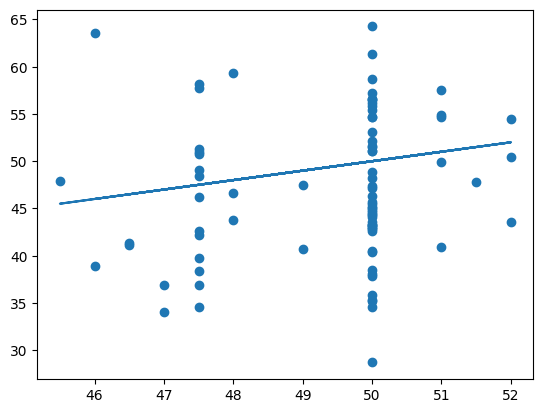

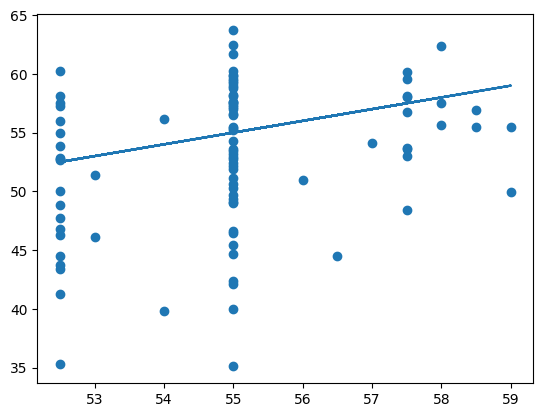

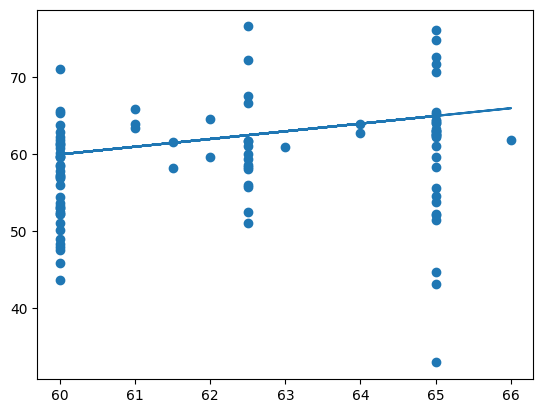

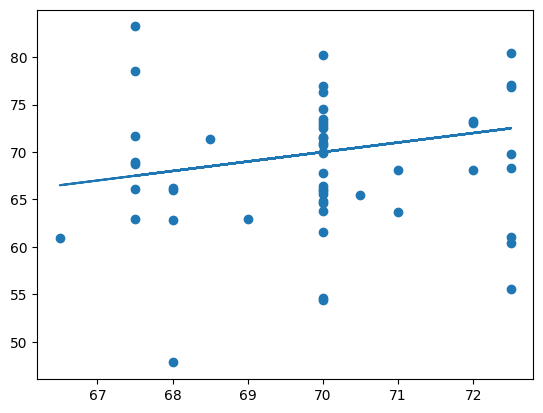

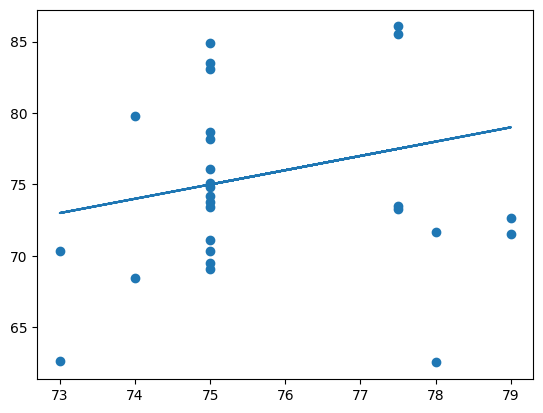

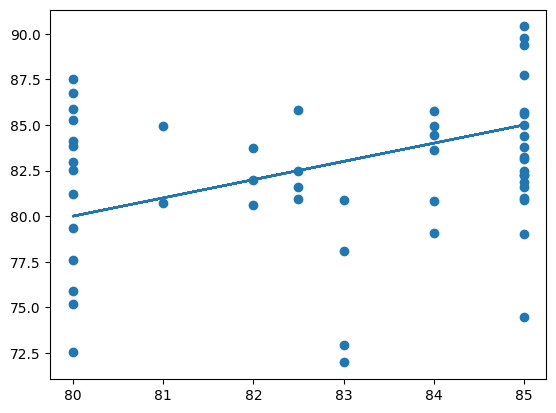

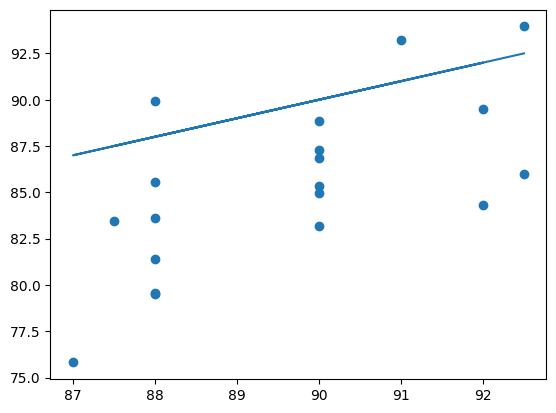

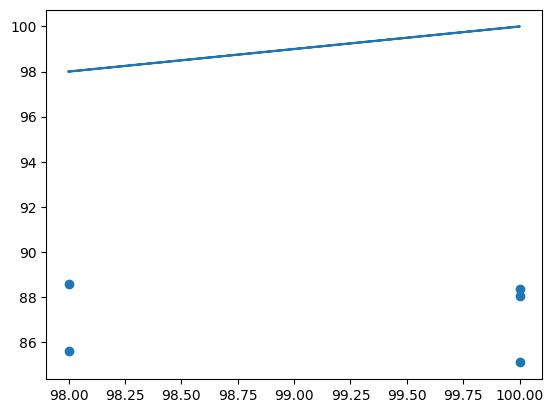

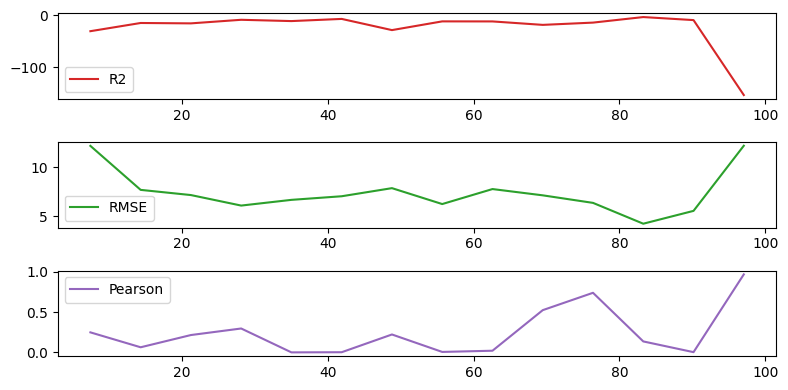

In [6]:
from scipy.stats import pearsonr

num_bins = 15
min_temp = min(y_true_cv.squeeze())
max_temp = max(y_true_cv.squeeze())

bins = np.linspace(min_temp, max_temp, num_bins)
bins_mid = []

cv_r2_curve = []
cv_rmse_curve = []
cv_pearson_curve = []


for i in range(num_bins-1):
    low = bins[i]
    high = bins[i+1]
    bins_mid.append(low+(high-low)/2)
    mask  = (y_true_cv >= low) & (y_true_cv < high)

    cv_r2 = r2_score(y_true_cv.squeeze()[mask], y_pred_cv[mask])
    cv_r2_curve.append(cv_r2)

    rmse_cv = np.sqrt(mean_squared_error(y_true_cv[mask], y_pred_cv[mask]))
    cv_rmse_curve.append(rmse_cv)

    r, p = pearsonr(y_true_cv[mask], y_pred_cv[mask])
    cv_pearson_curve.append(p)

    plt.figure()
    plt.scatter(y_true_cv[mask], y_pred_cv[mask])
    plt.plot(y_true_cv[mask], y_true_cv[mask])


plt.figure(figsize=(8, 4))
plt.subplot(3, 1, 1) 
plt.plot(bins_mid, cv_r2_curve, label = "R2", c = "tab:red")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(bins_mid, cv_rmse_curve, label = "RMSE", c = "tab:green")
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(bins_mid, cv_pearson_curve, label = "Pearson", c = "tab:purple")
plt.legend()

plt.tight_layout()  

In [33]:
cv_pearson_curve

[1.6e-43, 0.0, 3e-45, 9.785304e-09]

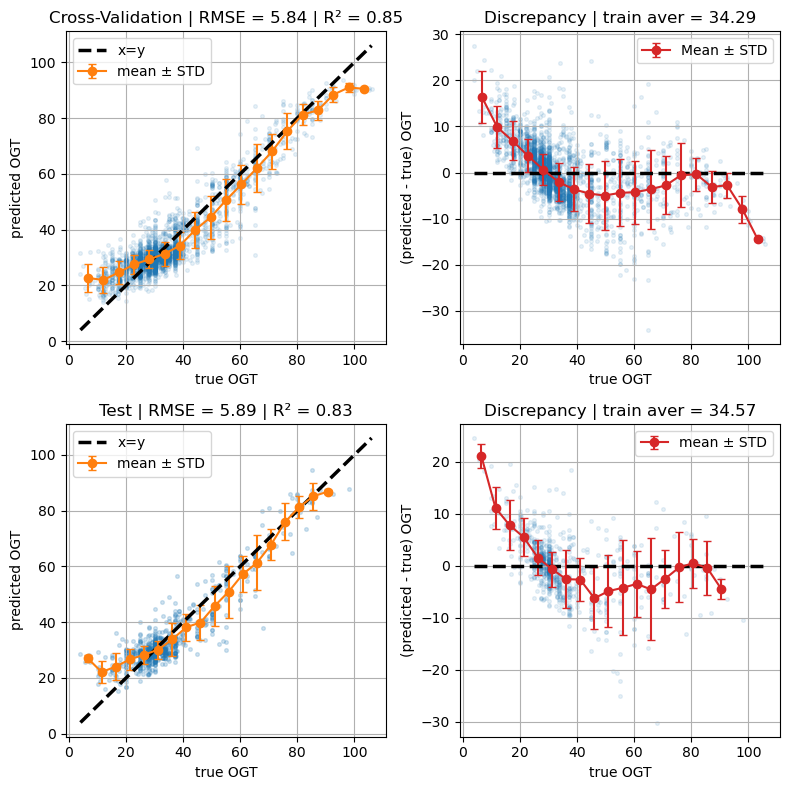

In [5]:
plt.figure(figsize=(8, 8))

num_bins = 20
min_temp = min(y_true_cv.squeeze())
max_temp = max(y_true_cv.squeeze())

# Cross-Validation: prediction vs actual
plt.subplot(2, 2, 1) 
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.1, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), y_pred_cv.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Cross-Validation | RMSE = {rmse_cv:.2f} | R² = {r2_cv:.2f}")
plt.legend()
plt.grid(True)

# Cross-Validation: (prediction - actual)
plt.subplot(2, 2, 2) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none') 
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='Mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_train:.2f}")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3) 
#y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train, y_train, X_test, y_test)
plt.scatter(y_test.cpu(), y_pred_test, marker='o', alpha = 0.2, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.cpu().squeeze(), y_pred_test.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Test | RMSE = {rmse_test:.2f} | R² = {r2_test:.2f}")
plt.grid(True)
plt.legend()

# Diff for full signal  
plt.subplot(2, 2, 4) 
y_test = y_test.cpu()
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_pred_test))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_test.cpu(), diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none')    
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_test:.2f}")
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()  
#plt.savefig(f"{OUTPUT_DIRECTORY}/baseline_cv_test_accuracy_all_feat.pdf", format="pdf")
plt.show()

In [ ]:
from utils.utils import train_xgboost, calculate_aver_std
from sklearn.metrics import mean_squared_error,r2_score
from xgboost import XGBRegressor

model = XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.05).fit(X_train.cpu(), y_train.cpu())
num_bins=20
#model = XGBRegressor(reg_alpha=1.0,reg_lambda=1.0, max_depth=3,subsample=0.8, colsample_bytree=0.8, n_estimators=100,learning_rate=0.05).fit(X_train.cpu(), y_train.cpu())

y_true_cv, y_pred_cv, y_pred_test  = train_xgboost(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), weights=None, model=model) 

#y_true_cv = y_true_cv.flatten()
# y_pred_cv = y_pred_cv.flatten()

#X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()
#preds = model.predict(X_train.cpu())
rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2_cv = r2_score(y_true_cv, y_pred_cv)
print(f"rmse_cv = {rmse_cv}; r2_cv = {r2_cv}")

plt.figure()
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.1, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), y_pred_cv.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:green', capsize=3, label='CV mean ± STD')

plt.plot(y_test.cpu(), y_test.cpu(), c="black")
#plt.scatter(y_true_cv, y_pred_cv, alpha= 0.1)



rmse_test = np.sqrt(mean_squared_error(y_test.cpu(), y_pred_test))
r2_test = r2_score(y_test.cpu(), y_pred_test)
print(f"rmse_test = {rmse_test}; r2_test = {r2_test}")

plt.scatter(y_test.cpu(), y_pred_test, marker='o', alpha = 0.2, c = "tab:orange", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.cpu().squeeze(), y_pred_test.squeeze(), num_bins)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.cpu().flatten(), y_pred_test, num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.legend()


## Step 2: Train Models on Data Segments

low_q = 20; high_q = 45
num low = 227; num mid = 2244; num high = 531;


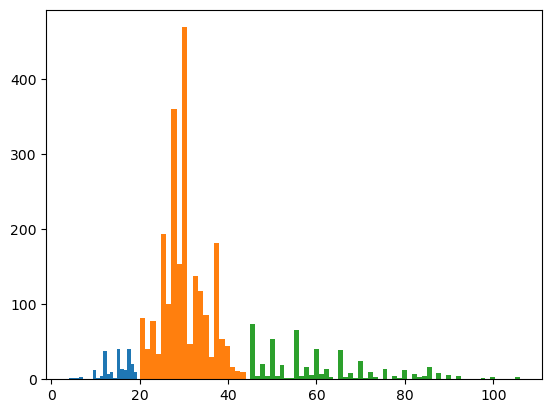

In [6]:
#y_train_log = np.log1p(y_train)
#y_test_log = np.log1p(y_test)

# Flatten y_train to 1D
y_train_flat = y_train.cpu().flatten()

# Compute quantiles from the flattened version
low_q = 20#np.quantile(y_train_flat, 1/3)
high_q = 45#np.quantile(y_train_flat, 2/3)
print(f"low_q = {low_q}; high_q = {high_q}")

# Define masks (all 1D)
low_mask  = y_train_flat < low_q
mid_mask  = (y_train_flat >= low_q) & (y_train_flat < high_q)
high_mask = y_train_flat >= high_q

# Apply masks correctly
X_low, y_low   = X_train[low_mask].cpu(), y_train_flat[low_mask].cpu()
X_mid, y_mid   = X_train[mid_mask].cpu(), y_train_flat[mid_mask].cpu()
X_high, y_high = X_train[high_mask].cpu(), y_train_flat[high_mask].cpu()

plt.hist(y_low, bins=20)
plt.hist(y_mid, bins=20)
plt.hist(y_high, bins=55)

print(f"num low = {len(y_low)}; num mid = {len(y_mid)}; num high = {len(y_high)};")

In [8]:
high_q

55.0

In [7]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

#model = XGBRegressor(reg_alpha=1.0,reg_lambda=1.0, max_depth=3,subsample=0.8, colsample_bytree=0.8, n_estimators=300,learning_rate=0.05)
model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05)

model_low  = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05).fit(X_low, y_low)
model_mid  =  XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05).fit(X_mid, y_mid)
model_high =  XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05).fit(X_high, y_high)

In [8]:
def evaluate_model(model, X_test, y_test, segment_name):
    preds = model.predict(X_test)

    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds, squared=False)

    print(f"\nPerformance on {segment_name} segment:")
    print(f"  R²   : {r2:.3f}")
    print(f"  MAE  : {mae:.3f}")
    print(f"  RMSE : {rmse:.3f}")
    return r2, mae, rmse

In [9]:
# Optionally: split y_test the same way as y_train
y_test_flat = y_test.flatten()
# low_q = np.quantile(y_train.flatten(), 1/3)
# high_q = np.quantile(y_train.flatten(), 2/3)

# # Create test masks
# low_mask_test  = y_test_flat < low_q
# mid_mask_test  = (y_test_flat >= low_q) & (y_test_flat < high_q)
# high_mask_test = y_test_flat >= high_q

low_mask_test  = y_test_flat < low_q
mid_mask_test  = (y_test_flat >= low_q) & (y_test_flat < high_q)
high_mask_test = y_test_flat >= high_q

# Test splits
X_test_low, y_test_low   = X_test[low_mask_test].cpu(), y_test_flat[low_mask_test].cpu()
X_test_mid, y_test_mid   = X_test[mid_mask_test].cpu(), y_test_flat[mid_mask_test].cpu()
X_test_high, y_test_high = X_test[high_mask_test].cpu(), y_test_flat[high_mask_test].cpu()

In [10]:

# Evaluate each model
evaluate_model(model_low,  X_test_low.cpu(),  y_test_low.cpu(),  "Low")
evaluate_model(model_mid,  X_test_mid.cpu(),  y_test_mid.cpu(),  "Mid")
evaluate_model(model_high, X_test_high.cpu(), y_test_high.cpu(), "High")


Performance on Low segment:
  R²   : -0.016
  MAE  : 2.876
  RMSE : 3.795

Performance on Mid segment:
  R²   : 0.335
  MAE  : 2.951
  RMSE : 3.887

Performance on High segment:
  R²   : 0.836
  MAE  : 4.192
  RMSE : 5.229


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(0.8356407880783081, 4.192266, 5.2292156)

In [12]:
gain_dict = model_low.get_booster().get_score(importance_type='gain')
total_gain = sum(gain_dict.values()) / len(y_low)
print(f"Tot gain in low model = {total_gain}")

gain_dict = model_mid.get_booster().get_score(importance_type='gain')
total_gain = sum(gain_dict.values()) / len(y_mid)
print(f"Tot gain in mid model = {total_gain}")

gain_dict = model_high.get_booster().get_score(importance_type='gain')
total_gain = sum(gain_dict.values()) / len(y_high)
print(f"Tot gain in high model = {total_gain}")

Tot gain in low model = 28.93443082939702
Tot gain in mid model = 50.24706359529028
Tot gain in high model = 167.84026299578377


## Step 3: Normalize Sensitivity via Target Transform or Weights


### Log-Transforming Target

In [17]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Define the baseline (for all features) XGBoost accuracy
y_true_cv, y_pred_cv, y_pred_test  = train_xgboost(X_train.cpu(), y_train_log.cpu(), X_test.cpu(), y_test_log.cpu(), weights=None) 

rmse_test = np.sqrt(mean_squared_error(y_test.cpu(), y_pred_test))
r2_test = r2_score(y_test.cpu(), y_pred_test)

rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2_cv = r2_score(y_true_cv, y_pred_cv)

print(f"XGBoost baseline test RMSE (all features) = {rmse_test:.2f}, R2 = {r2_test:.2f}")
print(f"XGBoost baseline CV RMSE (all features) = {rmse_cv:.2f}, R2 = {r2_cv:.2f}")

XGBoost baseline test RMSE (all features) = 38.27, R2 = -3.44
XGBoost baseline CV RMSE (all features) = 0.23, R2 = 0.79


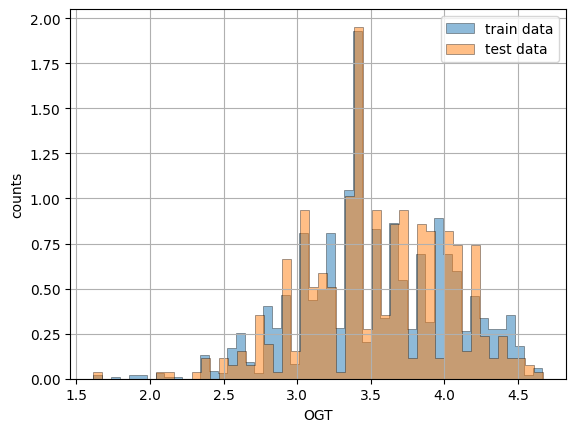

In [18]:
hist = plt.hist(y_train_log.cpu(), bins = 50, density = True, label = "train data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
hist = plt.hist(y_test_log.cpu(), bins = 50, density = True, label = "test data", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
plt.xlabel("OGT")
plt.ylabel("counts")
plt.grid(True)
plt.legend();

In [13]:
y_true_cv = np.expm1(y_true_cv)
y_pred_cv = np.expm1(y_pred_cv)
y_pred_test = np.expm1(y_pred_test)

rmse_test = np.sqrt(mean_squared_error(y_test.cpu(), y_pred_test))
r2_test = r2_score(y_test.cpu(), y_pred_test)

rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2_cv = r2_score(y_true_cv, y_pred_cv)

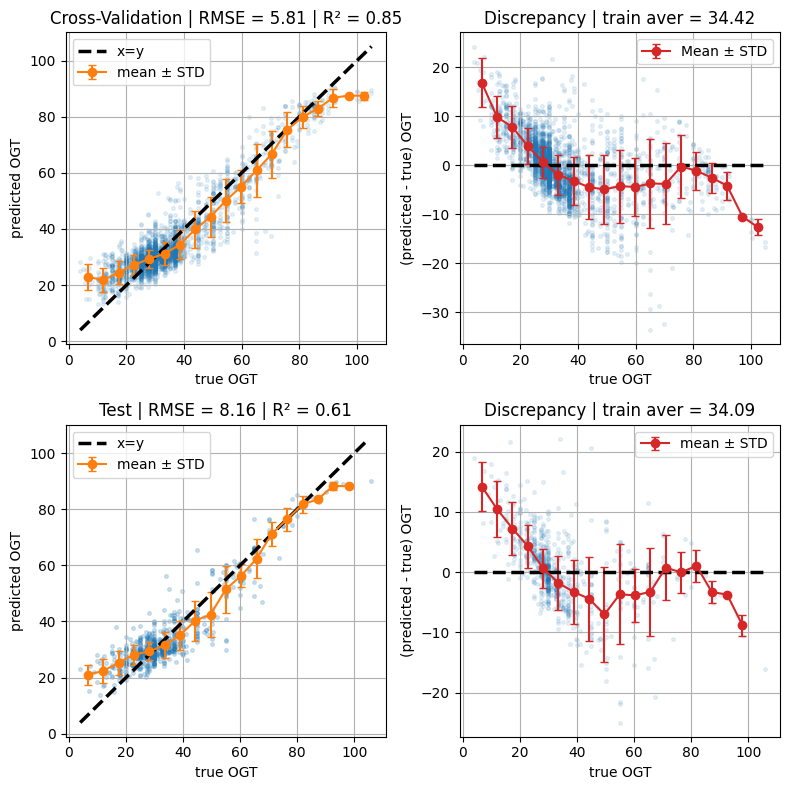

In [49]:
plt.figure(figsize=(8, 8))

num_bins = 20
min_temp = min(y_true_cv.squeeze())
max_temp = max(y_true_cv.squeeze())

# Cross-Validation: prediction vs actual
plt.subplot(2, 2, 1) 
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.1, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), y_pred_cv.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Cross-Validation | RMSE = {rmse_cv:.2f} | R² = {r2_cv:.2f}")
plt.legend()
plt.grid(True)

# Cross-Validation: (prediction - actual)
plt.subplot(2, 2, 2) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none') 
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='Mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_train:.2f}")
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3) 
#y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train, y_train, X_test, y_test)
plt.scatter(y_test.cpu(), y_pred_test, marker='o', alpha = 0.2, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.cpu().squeeze(), y_pred_test.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Test | RMSE = {rmse_test:.2f} | R² = {r2_test:.2f}")
plt.grid(True)
plt.legend()

# Diff for full signal  
plt.subplot(2, 2, 4) 
y_test = y_test.cpu()
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_pred_test))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_test.cpu(), diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none')    
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_test:.2f}")
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()  
#plt.savefig(f"{OUTPUT_DIRECTORY}/baseline_cv_test_accuracy_all_feat.pdf", format="pdf")
plt.show()

### Weighting Samples

[ 201.000001 1691.000001  650.000001  246.000001  126.000001   75.000001
   11.000001    2.000001]
1691
[1.84932548 1.         1.5933878  1.82367471 1.89207676 1.92114763
 1.95762873 1.96275888]


1.0

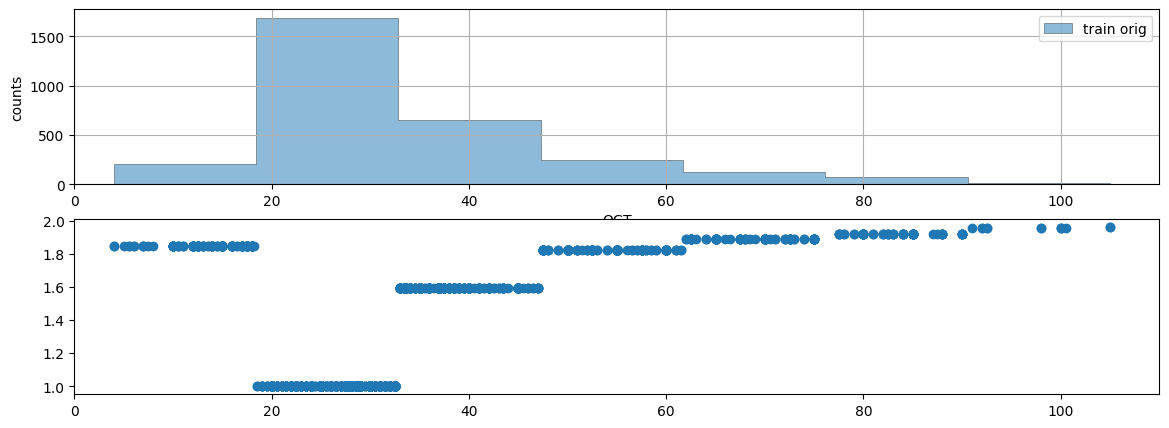

In [9]:
from utils.utils import train_xgboost
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from utils.utils import train_xgboost, calculate_aver_std

y_np = y_train.squeeze().cpu().numpy()

# Step 1: Bin the continuous values
num_bins = 7
bin_edges = np.linspace(y_np.min(), y_np.max(), num_bins + 1)
bin_indices = np.digitize(y_np, bins=bin_edges) - 1

# Step 2: Count samples in each bin
bin_counts = np.bincount(bin_indices, minlength=num_bins)

# Step 3: Scale weights between 1 (for max bin count) and 50 (for min bin count)
min_count = bin_counts.min()
max_count = bin_counts.max()

# Avoid division by zero if bins are empty
bin_counts_safe = bin_counts + 1e-6

# Normalize so max_count → weight 1, min_count → weight 50
bin_weights = 1- bin_counts / max_count#(max_count / bin_counts_safe)
bin_weights = bin_weights / sum(bin_weights)
bin_weights = 1 + bin_weights*6
print(bin_counts_safe)
print(max_count)
print(bin_weights)
# bin_weights[-1]=0
# bin_weights[-2]=0
# bin_weights[-3]=0
#bin_weights = 1 + (bin_weights - 1) * (5 - 1) / (bin_weights.max() - 1)

# Step 4: Assign sample weights
weights = bin_weights[bin_indices]
#weights /= weights.mean()

plt.figure(figsize=(14, 5))

plt.subplot(2, 1, 1) 
hist = plt.hist(y_train.cpu(), bins =num_bins, density = False, label = "train orig", alpha = 0.5, histtype='stepfilled', edgecolor='black', linewidth=0.5)
plt.xlabel("OGT")
plt.ylabel("counts")
plt.grid(True)
plt.xlim([0, 110])
plt.legend();

plt.subplot(2, 1, 2) 
plt.scatter(y_train.cpu(), weights)
plt.xlim([0, 110])
min(weights)

In [10]:
model = XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.05)

# Define the baseline (for all features) XGBoost accuracy
y_true_cv, y_pred_cv, y_pred_test, model  = train_xgboost(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), weights=weights, model=model) 

rmse_test = np.sqrt(mean_squared_error(y_test.cpu(), y_pred_test))
r2_test = r2_score(y_test.cpu(), y_pred_test)

rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
r2_cv = r2_score(y_true_cv, y_pred_cv)

print(f"XGBoost baseline CV RMSE (all features) = {rmse_cv:.2f}, R2 = {r2_cv:.2f}")
print(f"XGBoost baseline test RMSE (all features) = {rmse_test:.2f}, R2 = {r2_test:.2f}")

XGBoost baseline CV RMSE (all features) = 5.64, R2 = 0.86
XGBoost baseline test RMSE (all features) = 5.81, R2 = 0.83


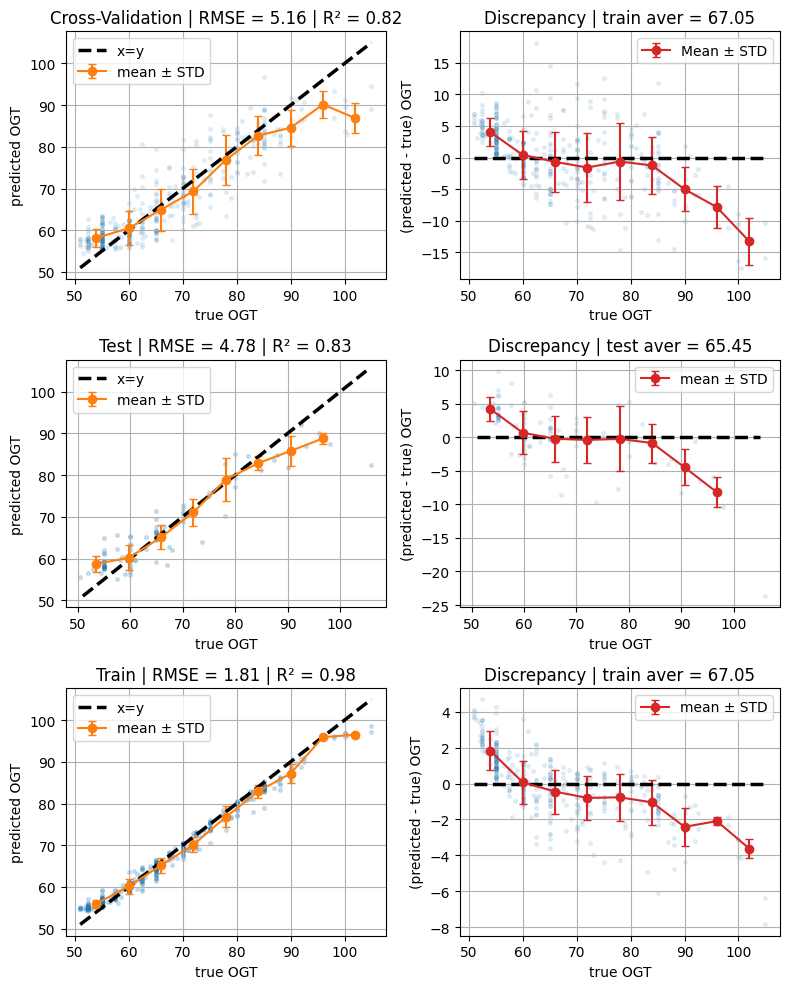

In [15]:
plt.figure(figsize=(8, 10))

num_bins = 10
min_temp = min(y_true_cv.squeeze())
max_temp = max(y_true_cv.squeeze())

# Cross-Validation: prediction vs actual
plt.subplot(3, 2, 1) 
plt.scatter(y_true_cv, y_pred_cv, marker='o', alpha = 0.1, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), y_pred_cv.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Cross-Validation | RMSE = {rmse_cv:.2f} | R² = {r2_cv:.2f}")
plt.legend()
plt.grid(True)

# Cross-Validation: (prediction - actual)
plt.subplot(3, 2, 2) 
diff = [y_pred_cv[i] - y_true_cv[i] for i in range(len(y_true_cv))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_true_cv, diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none') 
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='Mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_train:.2f}")
plt.legend()
plt.grid(True)

plt.subplot(3, 2, 3) 
#y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train, y_train, X_test, y_test)
plt.scatter(y_test.cpu(), y_pred_test, marker='o', alpha = 0.2, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.cpu().squeeze(), y_pred_test.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Test | RMSE = {rmse_test:.2f} | R² = {r2_test:.2f}")
plt.grid(True)
plt.legend()

# Diff for full signal  
plt.subplot(3, 2, 4) 
y_test = y_test.cpu()
diff = [y_pred_test[i] - y_test[i] for i in range(len(y_pred_test))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_test.cpu(), diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none')    
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | test aver = {mean_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 2, 5) 
#y_true_cv, y_pred_cv, y_pred_test = train_xgboost(X_train, y_train, X_test, y_test)
y_pred = model.predict(X_train.cpu())
plt.scatter(y_train.cpu(),y_pred, marker='o', alpha = 0.2, c = "tab:blue", s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_train.cpu().squeeze(), y_pred.squeeze(), num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
rmse_train = np.sqrt(mean_squared_error(y_train.cpu(),y_pred))
r2_train = r2_score(y_train.cpu(),y_pred)
plt.title(f"Train | RMSE = {rmse_train:.2f} | R² = {r2_train:.2f}")
plt.grid(True)
plt.legend()

plt.subplot(3, 2, 6) 
y_test = y_test.cpu()
diff = [y_pred.squeeze()[i] - y_train.cpu().squeeze().numpy()[i]  for i in range(len(y_pred))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_train.cpu().squeeze().numpy(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_train.cpu(), diff, marker='o', alpha = 0.1, c = "tab:blue", s=7, facecolor='none')    
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | train aver = {mean_train:.2f}")
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()  
plt.show()

In [30]:
y_train.cpu().squeeze().numpy()

array([  5. ,   5.5,   4. , ..., 100. , 100. , 100.5], dtype=float32)

In [31]:
y_pred.squeeze()

array([10.502221,  7.775348,  5.621496, ..., 94.268684, 96.086395,
       95.95639 ], dtype=float32)

### Test Generalization Between Segments

In [16]:
y_low[:10]
preds

NameError: name 'preds' is not defined

In [22]:
preds = model_low.predict(X_low)
preds[:10]

array([23.6208  , 25.35663 , 25.27836 , 20.841986, 25.772318, 24.84976 ,
       19.884983, 26.390766, 25.685076, 19.68506 ], dtype=float32)

In [54]:
# y_low = np.expm1(y_low)
# y_mid = np.expm1(y_mid)
# y_high = np.expm1(y_high)


In [56]:
# y_test_low = np.expm1(y_test_low)
# y_test_mid = np.expm1(y_test_mid)
# y_test_high = np.expm1(y_test_high)

In [44]:
preds = model_low.predict(X_mid)
preds_test = model_low.predict(X_test_mid)
rmse_test = np.sqrt(mean_squared_error(y_test_mid, preds_test))
r2_test =  r2_score(y_test_mid, preds_test)
r2_test

-23.651071548461914

In [28]:
#model_mid  =  XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.05).fit(X_mid, y_mid)
model_mid  =  XGBRegressor(n_estimators=200, max_depth=7, learning_rate=0.05).fit(X_mid, y_mid)

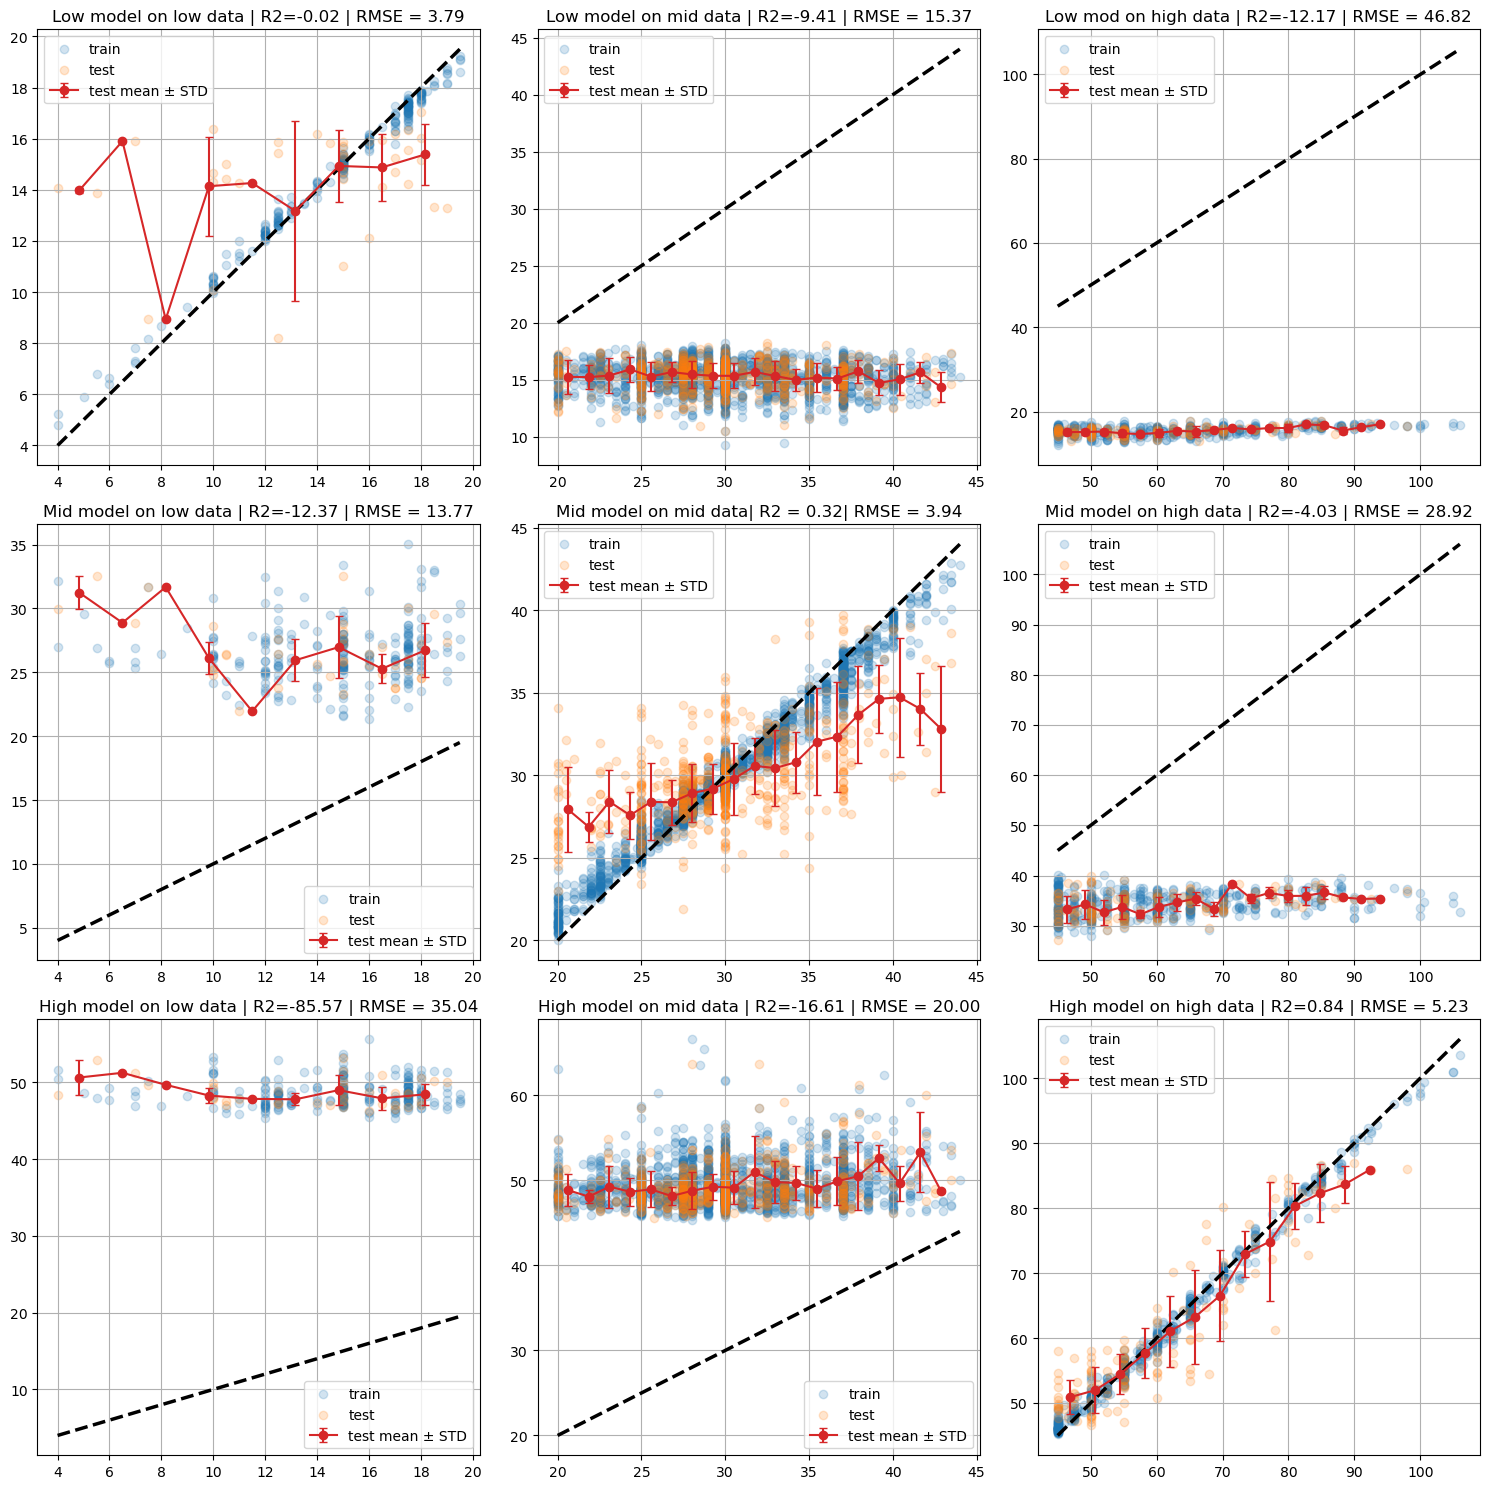

In [29]:
plt.figure(figsize=(15, 15))


plt.subplot(3, 3, 1) 
preds = model_low.predict(X_low)
plt.scatter(y_low, preds, alpha = 0.2, label = "train")
preds_test = model_low.predict(X_test_low)
rmse_test = np.sqrt(mean_squared_error(y_test_low, preds_test))
r2_test =  r2_score(y_test_low, preds_test)
plt.scatter(y_test_low.flatten(), preds_test, alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_low.flatten(), preds_test, 10)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.plot([min(y_low),max(y_low)],[min(y_low),max(y_low)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Low model on low data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)

plt.subplot(3, 3, 2) 
preds = model_low.predict(X_mid)
preds_test = model_low.predict(X_test_mid)
rmse_test = np.sqrt(mean_squared_error(y_test_mid, preds_test))
r2_test =  r2_score(y_test_mid, preds_test)
plt.scatter(y_mid, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_mid.flatten(), preds_test, alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_mid.flatten(), preds_test, num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.plot([min(y_mid),max(y_mid)],[min(y_mid),max(y_mid)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Low model on mid data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 3, 3) 
preds = model_low.predict(X_high)
preds_test = model_low.predict(X_test_high)
rmse_test = np.sqrt(mean_squared_error(y_test_high, preds_test))
r2_test = r2_score(y_test_high, preds_test)
plt.scatter(y_high, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_high.flatten(), model_low.predict(X_test_high), alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_high.flatten(), preds_test, num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.plot([min(y_high),max(y_high)],[min(y_high),max(y_high)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Low mod on high data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 3, 4) 
preds = model_mid.predict(X_low)
preds_test = model_mid.predict(X_test_low)
rmse_test = np.sqrt(mean_squared_error(y_test_low, preds_test))
r2_test = r2_score(y_test_low, preds_test)
plt.scatter(y_low, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_low.flatten(), model_mid.predict(X_test_low), alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_low.flatten(), preds_test, 10)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.plot([min(y_low),max(y_low)],[min(y_low),max(y_low)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Mid model on low data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 3, 5) 
preds = model_mid.predict(X_mid)
preds_test = model_mid.predict(X_test_mid)
rmse_test = np.sqrt(mean_squared_error(y_test_mid, preds_test))
r2_test = r2_score(y_test_mid, preds_test)
plt.scatter(y_mid, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_mid.flatten(), model_mid.predict(X_test_mid), alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_mid.flatten(), preds_test, num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.plot([min(y_mid),max(y_mid)],[min(y_mid),max(y_mid)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Mid model on mid data| R2 = {r2_test:.2f}| RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 3, 6) 
preds = model_mid.predict(X_high)
preds_test = model_mid.predict(X_test_high)
rmse_test = np.sqrt(mean_squared_error(y_test_high, preds_test))
r2_test = r2_score(y_test_high, preds_test)
plt.scatter(y_high, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_high.flatten(), model_mid.predict(X_test_high), alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_high.flatten(), preds_test, num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.plot([min(y_high),max(y_high)],[min(y_high),max(y_high)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Mid model on high data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 3, 7) 
preds = model_high.predict(X_low)
preds_test = model_high.predict(X_test_low)
rmse_test = np.sqrt(mean_squared_error(y_test_low, preds_test))
r2_test = r2_score(y_test_low, preds_test)
plt.scatter(y_low, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_low.flatten(), model_high.predict(X_test_low), alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_low.flatten(), preds_test, 10)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.plot([min(y_low),max(y_low)],[min(y_low),max(y_low)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"High model on low data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 3, 8) 
preds = model_high.predict(X_mid)
preds_test = model_high.predict(X_test_mid)
rmse_test = np.sqrt(mean_squared_error(y_test_mid, preds_test))
r2_test = r2_score(y_test_mid, preds_test)
plt.scatter(y_mid, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_mid.flatten(), model_high.predict(X_test_mid), alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_mid.flatten(), preds_test, num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.plot([min(y_mid),max(y_mid)],[min(y_mid),max(y_mid)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"High model on mid data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(3, 3, 9) 
preds = model_high.predict(X_high)
preds_test = model_high.predict(X_test_high)
rmse_test = np.sqrt(mean_squared_error(y_test_high.flatten(), preds_test))
r2_test = r2_score(y_test_high.flatten(), preds_test)
plt.scatter(y_high, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_high.flatten(), model_high.predict(X_test_high), alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_high.flatten(), preds_test, 15)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.plot([min(y_high),max(y_high)],[min(y_high),max(y_high)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"High model on high data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)

plt.tight_layout()

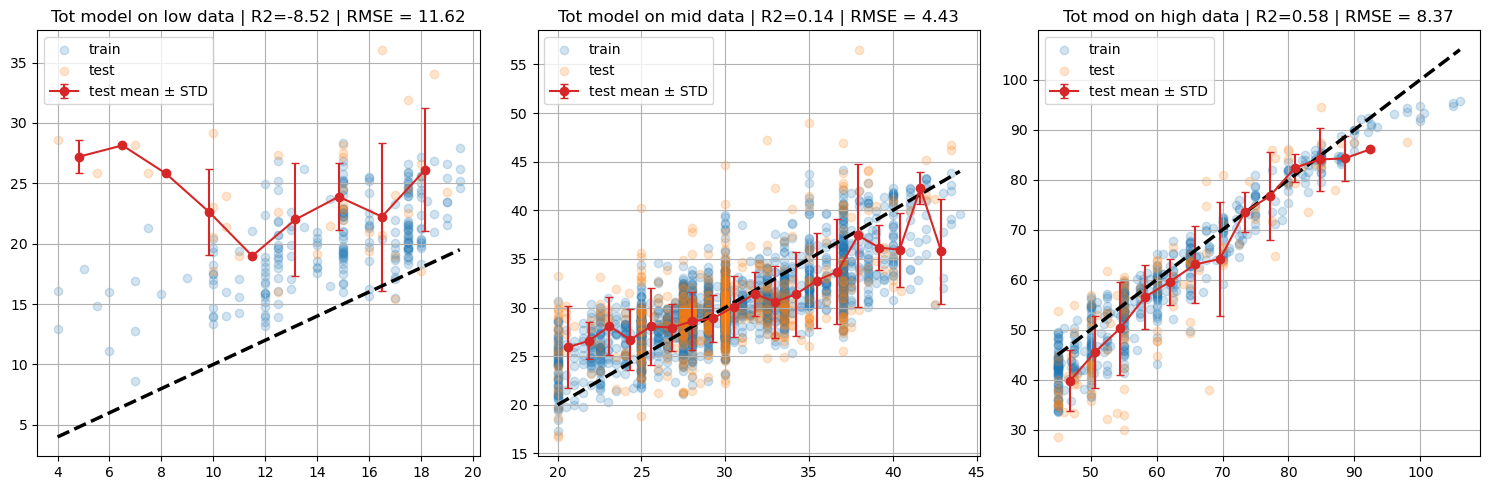

In [103]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1) 
preds = model.predict(X_low)
plt.scatter(y_low, preds, alpha = 0.2, label = "train")
preds_test = model.predict(X_test_low)
rmse_test = np.sqrt(mean_squared_error(y_test_low, preds_test))
r2_test =  r2_score(y_test_low, preds_test)
plt.scatter(y_test_low.flatten(), preds_test, alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_low.flatten(), preds_test, 10)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.plot([min(y_low),max(y_low)],[min(y_low),max(y_low)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Tot model on low data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2) 
preds = model.predict(X_mid)
preds_test = model.predict(X_test_mid)
rmse_test = np.sqrt(mean_squared_error(y_test_mid, preds_test))
r2_test =  r2_score(y_test_mid, preds_test)
plt.scatter(y_mid, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_mid.flatten(), preds_test, alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_mid.flatten(), preds_test, num_bins)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.plot([min(y_mid),max(y_mid)],[min(y_mid),max(y_mid)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Tot model on mid data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)


plt.subplot(1, 3, 3) 
preds = model.predict(X_high)
preds_test = model.predict(X_test_high)
rmse_test = np.sqrt(mean_squared_error(y_test_high, preds_test))
r2_test = r2_score(y_test_high, preds_test)
plt.scatter(y_high, preds, alpha = 0.2, label = "train")
plt.scatter(y_test_high.flatten(), model.predict(X_test_high), alpha = 0.2, label = "test")
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_high.flatten(), preds_test, 15)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.plot([min(y_high),max(y_high)],[min(y_high),max(y_high)], c = "black", linestyle='--', linewidth=2.5)
plt.title(f"Tot mod on high data | R2={r2_test:.2f} | RMSE = {rmse_test:.2f}")
plt.legend()
plt.grid(True)

plt.tight_layout()

In [44]:
rmse_test = np.sqrt(mean_squared_error(y_test_high.flatten(), preds_test))
y_test_high.flatten()

tensor([ 55.0000,  70.0000,  68.0000,  70.0000,  61.0000,  65.0000,  75.0000,
         55.0000,  58.5000,  55.0000,  85.0000,  80.0000,  63.0000,  55.0000,
         70.0000,  65.0000,  65.0000,  92.5000,  65.0000,  65.0000,  75.0000,
         57.5000,  65.0000,  60.0000,  66.5000,  87.5000,  65.0000,  65.0000,
         60.0000,  63.0000,  88.0000,  60.0000,  78.0000,  60.0000,  60.0000,
         70.0000, 106.0000,  80.0000,  55.0000,  61.0000,  55.0000,  67.5000,
         60.0000,  70.0000,  60.0000,  65.0000,  55.0000,  55.0000,  55.0000,
         55.0000,  66.0000,  55.0000,  90.0000,  55.0000,  93.5000,  82.5000,
         60.0000,  65.0000,  66.5000,  55.0000,  96.0000,  55.0000,  60.0000,
         73.7500,  67.0000,  55.0000,  55.0000,  65.0000,  70.0000,  59.0000,
         60.0000,  58.0000,  55.0000,  57.5000,  80.0000,  65.0000,  60.0000,
         78.0000,  55.0000,  98.0000,  57.5000,  55.0000,  60.0000,  60.0000,
         65.0000])

In [45]:
preds_test

array([20.950802, 16.38699 , 17.901562, 20.002369, 22.644514, 18.399143,
       24.41452 , 20.224846, 20.817213, 18.012907, 17.84097 , 19.530651,
       18.69564 , 17.807138, 19.026072, 19.84941 , 17.248165, 18.164268,
       20.153627, 19.46568 , 20.117142, 23.048092, 22.903336, 18.687984,
       21.472334, 18.86089 , 19.572348, 17.628777, 21.33745 , 16.25778 ,
       18.25738 , 18.552498, 20.303951, 21.062202, 20.889841, 24.108276,
       19.17922 , 19.102001, 19.520498, 17.55997 , 16.796124, 17.83459 ,
       17.062977, 22.47972 , 15.964989, 17.371206, 22.940733, 17.142338,
       22.006357, 19.362398, 21.041834, 20.641148, 18.537   , 21.41995 ,
       19.555195, 17.981716, 19.371874, 16.801044, 16.754814, 21.79339 ,
       18.877054, 17.753548, 18.148361, 16.30684 , 23.49551 , 20.574594,
       21.700272, 17.992468, 21.108316, 21.767187, 23.98199 , 18.77506 ,
       20.112827, 17.224653, 24.318249, 17.196655, 15.284012, 17.794113,
       16.135479, 18.385748, 25.052837, 13.685175, 

### Top important features

Top 10 most important features by gain in the low model:
K16291: 868.31
K01589: 825.26
K10778: 740.54
K03547: 689.66
K03315: 646.25
K07032: 571.30
K13583: 540.03
K02046: 514.61
K09942: 506.79
K07141: 505.08


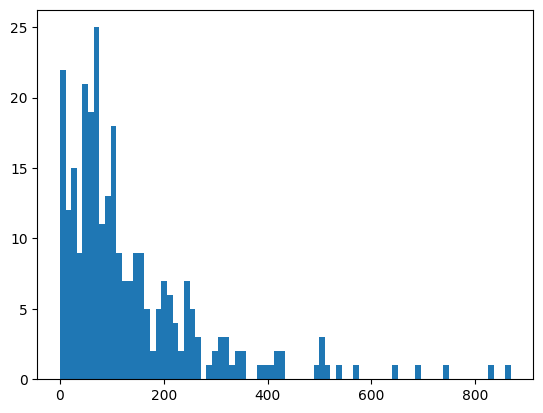

In [47]:
# Get feature importance scores (by gain)
gain_dict = model_low.get_booster().get_score(importance_type='gain')

# Sort features by gain, descending
sorted_gain = sorted(gain_dict.items(), key=lambda item: item[1], reverse=True)

# Extract top 10 features
top_10 = sorted_gain[:10]

# Display nicely
print("Top 10 most important features by gain in the low model:")
feature_map = dict(zip([f"f{i}" for i in range(X_train.shape[1])], X_column_names))
for f, score in top_10:
    print(f"{feature_map[f]}: {score:.2f}")

gain_scores = list(gain_dict.values())
plt.hist(gain_scores, bins=80);

Top 10 most important features by gain in the mid model:
K15342: 1023.22
K19091: 910.14
K06208: 567.92
K02407: 565.23
K01246: 551.16
K09954: 545.15
K00336: 527.76
K00260: 477.02
K09706: 446.20
K06384: 403.04


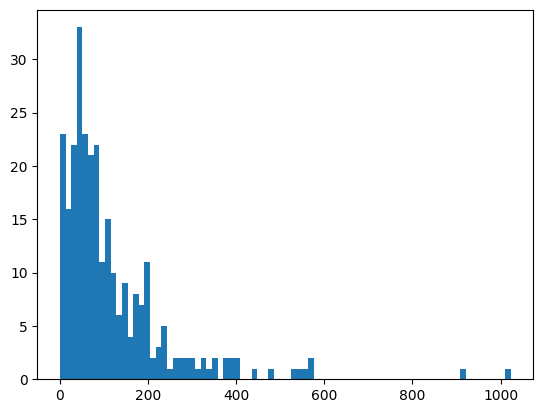

In [48]:
# Get feature importance scores (by gain)
gain_dict = model_mid.get_booster().get_score(importance_type='gain')

# Sort features by gain, descending
sorted_gain = sorted(gain_dict.items(), key=lambda item: item[1], reverse=True)

# Extract top 10 features
top_10 = sorted_gain[:10]

# Display nicely
print("Top 10 most important features by gain in the mid model:")
feature_map = dict(zip([f"f{i}" for i in range(X_train.shape[1])], X_column_names))
for f, score in top_10:
    print(f"{feature_map[f]}: {score:.2f}")

gain_scores = list(gain_dict.values())
plt.hist(gain_scores, bins=80);

Top 10 most important features by gain in the high model:
K04043: 12074.51
K06870: 5361.96
K03551: 2661.83
K03170: 1679.83
K05716: 1166.07
K03724: 791.04
K08482: 773.49
K04070: 687.14
K07658: 661.19
K07007: 655.17


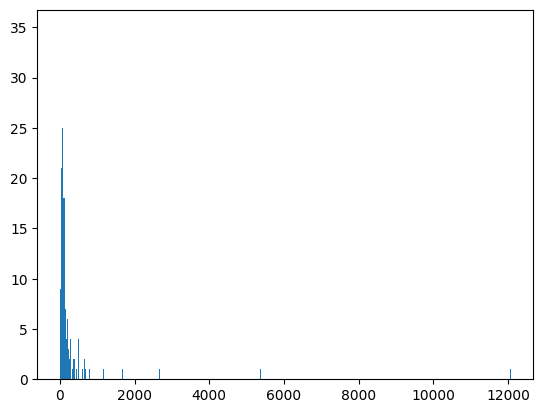

In [49]:
# Get feature importance scores (by gain)
gain_dict = model_high.get_booster().get_score(importance_type='gain')

# Sort features by gain, descending
sorted_gain = sorted(gain_dict.items(), key=lambda item: item[1], reverse=True)

# Extract top 10 features
top_10 = sorted_gain[:10]

# Display nicely
print("Top 10 most important features by gain in the high model:")
feature_map = dict(zip([f"f{i}" for i in range(X_train.shape[1])], X_column_names))
for f, score in top_10:
    print(f"{feature_map[f]}: {score:.2f}")

gain_scores = list(gain_dict.values())
plt.hist(gain_scores, bins=800);

### Vizualization 

Shape of the projected data = (3002, 2)


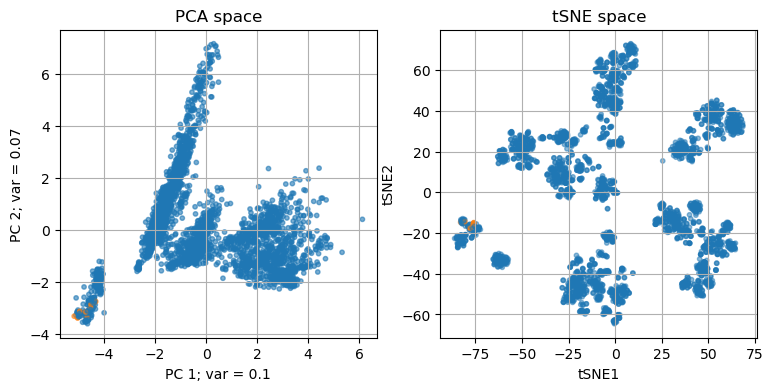

In [49]:
from utils.utils import pca_run_and_plot, tsne_plot
from matplotlib.colors import ListedColormap

y_train_masked = [5 if yi>90  else 0 for yi in y_train]

colors = ListedColormap(["tab:blue", "tab:orange"])
plt.figure(figsize=(9, 4))
X_train, y_train, X_test, y_test = X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu()

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 10
pca_run_and_plot(X_train, n_compon, y_train_masked, None, colors);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_train, 50, 100, RANDOM_SEED, y_train_masked, colors);

Shape of the projected data = (3002, 2)


Text(0.5, 0.98, 'Expression level of K00331')

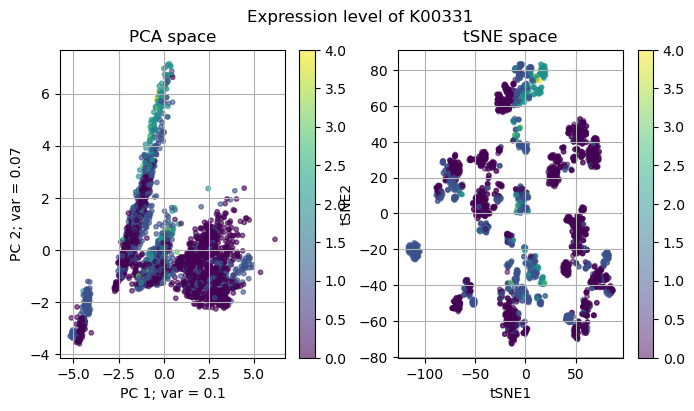

In [106]:
feature_name = 'K00331'
X_column_names = list(X_column_names)

if feature_name in X_column_names:
    idx = X_column_names.index(feature_name)
else:
    print(f"This feature doesn't exist in the feature space!")

feature_expression = X_train[:, idx]
feature_expression = feature_expression.cpu()

from matplotlib import cm
plt.figure(figsize=(8, 4))

# PCA space
plt.subplot(1, 2, 1) 
n_compon = 20
colorbar = True
colors = ListedColormap(cm.viridis(np.linspace(0, 1, len(feature_expression))))
pca_run_and_plot(X_train.cpu(), n_compon, feature_expression, None, colors, legend = False, colorbar = colorbar);

# t-SNE space
plt.subplot(1, 2, 2) 
tsne_plot(X_train.cpu(), 30, 100, RANDOM_SEED, feature_expression, colors, colorbar = colorbar);
plt.suptitle(f"Expression level of {feature_name}")

In [58]:
max(feature_expression)


tensor(3, dtype=torch.int32)

### Sliding window stuff

In [36]:
y_train_flat = y_train.flatten().cpu()
y_test_flat = y_test.flatten().cpu()

In [78]:
model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.05).fit(X_train.cpu(), y_train.cpu())
#XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.05).fit(X_high, y_high)

min_val = min(y_train_flat).cpu().item()
max_val = max(y_train_flat).cpu().item()
window_size = 10
step_size = 5
num_bins=20

windows = []
start = min_val
while start + window_size <= max_val:
    end = start + window_size
    windows.append((start, end))
    start += step_size

windiow_centers = []
r2_cv_arr = []
r2_test_arr = []
rmse_cv_arr = []
rmse_test_arr = []


r2_train_arr = []
rmse_train_arr = []

#plt.figure()

for window in windows:
    windiow_centers.append(np.mean(window))
    
    mask_train  = (y_train_flat >= window[0]) & (y_train_flat < window[1])
    X_train_mask, y_train_mask   = X_train[mask_train], y_train_flat[mask_train]

    mask_test  = (y_test_flat >= window[0]) & (y_test_flat < window[1])
    X_test_mask, y_test_mask = X_test[mask_test], y_test_flat[mask_test]

    weights = mask_train.long()
    weights = 1 - weights

    y_true_cv, y_pred_cv, y_pred_test, model  = train_xgboost(X_train.cpu(), y_train.cpu(), X_test.cpu(), y_test.cpu(), weights=weights, model=model) 
    
    r2_cv = r2_score(y_true_cv, y_pred_cv)
    rmse_cv = np.sqrt(mean_squared_error(y_true_cv, y_pred_cv))
    r2_cv_arr.append(r2_cv)
    rmse_cv_arr.append(rmse_cv)

    rmse_test = np.sqrt(mean_squared_error(y_test.cpu(), y_pred_test))
    r2_test = r2_score(y_test.cpu(), y_pred_test)
    if len(y_test) > 4:
        r2_test_arr.append(r2_test)
        rmse_test_arr.append(rmse_test)
    else:
        r2_test_arr.append(None)
        rmse_test_arr.append(None)

    print(len(y_test))

  #  plt.figure()
  #  plt.scatter(y_true_cv, y_pred_cv, label="cv", alpha=0.5)
  #  plt.scatter(y_test, y_pred_test, label="test", alpha=0.5)
  #  plt.plot(y_true_cv, y_true_cv, label="test", c="black")
    
    bin_centers, mean_diff, std_diff = calculate_aver_std(y_true_cv, y_pred_cv, num_bins)
 #   plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='CV test mean ± STD')
    
    bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.squeeze(), y_pred_test, num_bins)
 #   plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:green', capsize=3, label='test mean ± STD')

    #plt.scatter(y_train, model.predict(X_train.cpu()), c='tab:purple', label="training loss", alpha=0.5)
    rmse_train = np.sqrt(mean_squared_error(y_train.cpu(), model.predict(X_train.cpu())))
    r2_train = r2_score(y_train.cpu(), model.predict(X_train.cpu()))
    r2_train_arr.append(r2_train)
    rmse_train_arr.append(rmse_train)
  #  plt.legend()
    

C:\Users\kolda\OneDrive\Documents\gene-context\phenotype_prediction\jupyter_notebooks\utils\utils.py:598: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights_tensor_all = torch.tensor(weights, dtype=torch.float32)


KeyboardInterrupt: 

In [75]:
rmse_test_arr

[3.6134365,
 3.8625925,
 3.913023,
 3.952363,
 3.5756736,
 3.9317477,
 4.164081,
 4.472642,
 4.430765,
 4.278433,
 3.8153756,
 3.8656995,
 3.8282123,
 4.5476923,
 None,
 None,
 None]

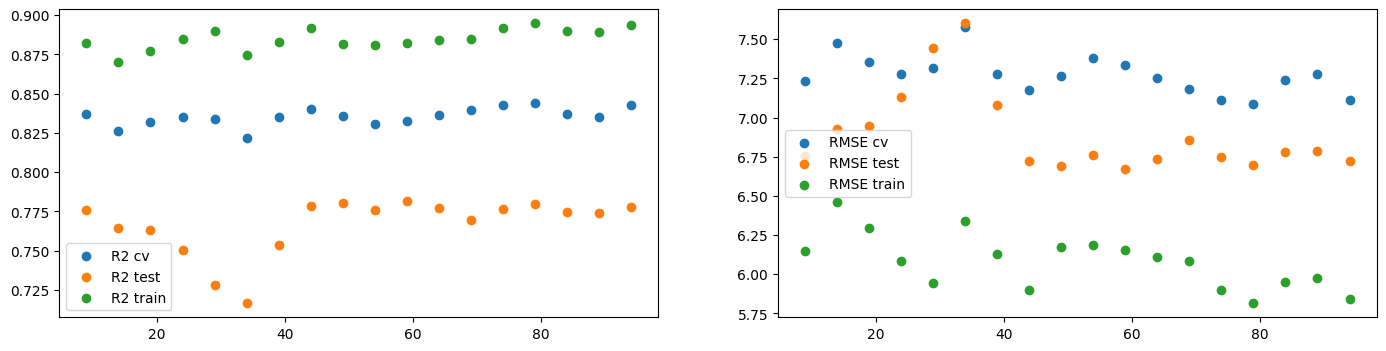

In [45]:
plt.figure(figsize=(17, 4))
plt.subplot(1, 2, 1)
plt.scatter(windiow_centers, r2_cv_arr, label = "R2 cv")
plt.scatter(windiow_centers, r2_test_arr, label = "R2 test")
plt.scatter(windiow_centers, r2_train_arr, label = "R2 train")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(windiow_centers, rmse_cv_arr, label = "RMSE cv")
plt.scatter(windiow_centers, rmse_test_arr, label = "RMSE test")
plt.scatter(windiow_centers, rmse_train_arr, label = "RMSE train")
plt.legend()

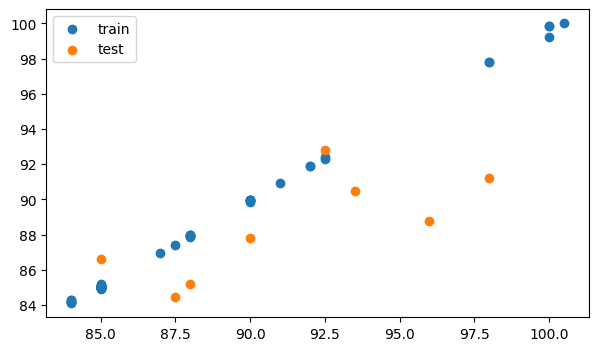

In [63]:
plt.figure(figsize=(7, 4))

preds = model_on_mask.predict(X_train_mask)
rmse_train = np.sqrt(mean_squared_error(y_train_mask, preds))
plt.scatter(y_train_mask, preds, label="train")
r2_train = r2_score(y_train_mask, preds)
r2_train_arr.append(r2_train)
rmse_train_arr.append(rmse_train)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_train_mask.cpu().squeeze(),preds, num_bins)
#plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')

mask_test  = (y_test_flat >= window[0]) & (y_test_flat < window[1])
X_test_mask, y_test_mask = X_test[mask_test], y_test_flat[mask_test]

preds = model_on_mask.predict(X_test_mask)
rmse_test = np.sqrt(mean_squared_error(y_test_mask, preds))
plt.scatter(y_test_mask, preds, label="test")
r2_test = r2_score(y_test_mask, preds)
r2_test_arr.append(r2_test)
rmse_test_arr.append(rmse_test)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test_mask.cpu().squeeze(),preds, num_bins)
#plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='test mean ± STD')
plt.legend()


### Mixture of experts model

In [60]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# --- 1. Label each sample as low, mid, or high OGT group
def label_ogt_range(y, low_thresh=20, high_thresh=45):
    labels = []
    for val in y:
        if val < low_thresh:
            labels.append('low')
        elif val <= high_thresh:
            labels.append('mid')
        else:
            labels.append('high')
    return np.array(labels)

# Assign labels
range_labels = label_ogt_range(y_train)

le = LabelEncoder()
range_ids = le.fit_transform(range_labels)  # Converts to 0,1,2

label_to_int = {'low': 0, 'mid': 1, 'high': 2}

# Vectorized conversion
range_ids = np.vectorize(label_to_int.get)(range_labels)

range_labels_test = label_ogt_range(y_test)
range_ids_test = np.vectorize(label_to_int.get)(range_labels_test)

In [88]:
range_labels

array(['mid', 'mid', 'mid', ..., 'high', 'mid', 'high'], dtype='<U4')

In [69]:
y_train

tensor([[22.0000],
        [29.0000],
        [33.5000],
        ...,
        [80.0000],
        [27.5000],
        [55.0000]])

(array([ 39., 589., 122.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

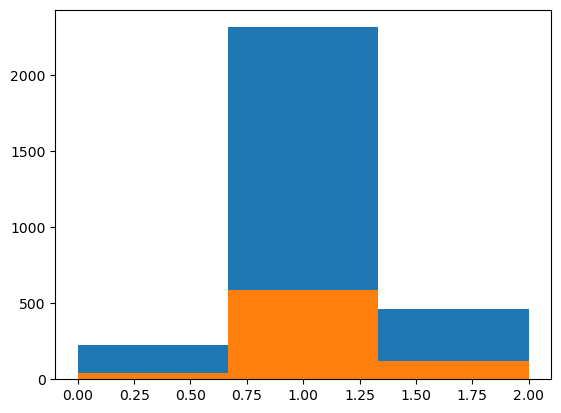

In [70]:
plt.hist(range_ids, bins=3)
plt.hist(range_ids_test, bins=3)

In [71]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Encode classes (0 = low, 1 = mid, 2 = high)
#range_ids = le.transform(label_ogt_range(y_train))

# Compute class weights
classes = np.unique(range_ids)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=range_ids)
#weights = [4.720125786163522, 0.4315078338364237, 2.1245576786978]

# Convert to dictionary format for xgboost
class_weights = dict(zip(classes, weights))

# Pass weights to each sample
sample_weights = np.array([class_weights[c] for c in range_ids])
class_weights

{0: 4.408223201174743, 1: 0.4322534197264219, 2: 2.1753623188405795}

In [58]:
y_train

tensor([[22.0000],
        [29.0000],
        [33.5000],
        ...,
        [80.0000],
        [27.5000],
        [55.0000]])

In [57]:
range_ids

array([1, 1, 1, ..., 2, 1, 2])

In [56]:
range_labels

array(['mid', 'mid', 'mid', ..., 'high', 'mid', 'high'], dtype='<U4')

In [59]:
label_to_int = {'low': 0, 'mid': 1, 'high': 2}

# Vectorized conversion
range_ids = np.vectorize(label_to_int.get)(range_labels)
range_ids

array([1, 1, 1, ..., 2, 1, 2])

In [97]:
# --- 2. Train gating model (classifier)
#gating_model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')



num_classes = 3
gating_model = XGBClassifier(
    n_jobs=-1,
    tree_method="hist",
    objective="multi:softmax",   # Multi-class classification
    num_class=num_classes,       # Number of target classes
    eval_metric="mlogloss",      # Suitable for multi-class
)

gating_model.fit(X_train.cpu(), range_ids,sample_weight=sample_weights )  # Predicts soft assignments to experts



# --- 4. Get gating probabilities (soft weights for each expert)
gate_probs = gating_model.predict_proba(X_test.cpu())  # Shape: (n_samples, 3)

In [98]:
gate_probs

array([[1.3650678e-03, 9.9324495e-01, 5.3899656e-03],
       [5.5016502e-04, 9.9908638e-01, 3.6346071e-04],
       [5.7911980e-01, 4.2069575e-01, 1.8438962e-04],
       ...,
       [1.1942344e-03, 9.9870420e-01, 1.0154245e-04],
       [1.1203343e-03, 9.9543971e-01, 3.4400227e-03],
       [1.9618482e-03, 9.9237388e-01, 5.6641554e-03]], dtype=float32)

In [229]:
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

# # Encode classes (0 = low, 1 = mid, 2 = high)
# range_ids = le.transform(label_ogt_range(y_train))

# # Compute class weights
# classes = np.unique(range_ids)
# weights = compute_class_weight(class_weight='balanced', classes=classes, y=range_ids)

# # Convert to dictionary format for xgboost
# class_weights = dict(zip(classes, weights))

# # Pass weights to each sample
# sample_weights = np.array([class_weights[c] for c in range_ids])

# from xgboost import XGBClassifier
# gating_model = XGBClassifier(
#     n_estimators=100,
#     max_depth=4,
#     learning_rate=0.1,
#     objective='multi:softprob',
#     eval_metric='mlogloss',
#     use_label_encoder=False
# )

# gating_model.fit(X_train, range_ids, sample_weight=sample_weights)

              precision    recall  f1-score   support

           0       0.68      0.33      0.45        39
           1       0.92      0.98      0.95       589
           2       0.94      0.83      0.88       122

    accuracy                           0.92       750
   macro avg       0.85      0.71      0.76       750
weighted avg       0.91      0.92      0.91       750



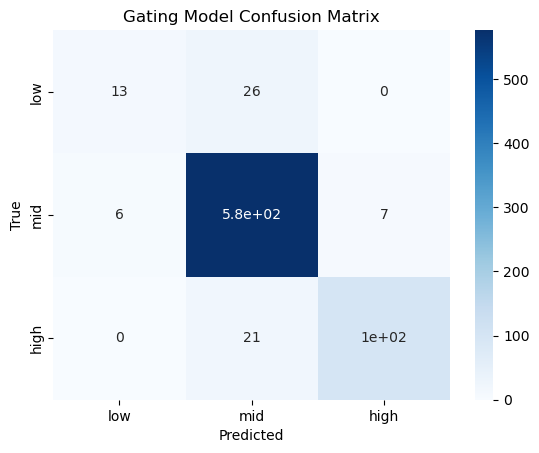

In [99]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

gate_preds = gating_model.predict(X_test.cpu()) 

#print(len(gate_preds))

print(classification_report(range_ids_test,gate_preds))

# Confusion matrix
cm = confusion_matrix(range_ids_test, gate_preds)
desired_order_x = [1, 2, 0]  # Modify based on your class arrangement
desired_order_y =  [1, 2, 0]

# Reorder columns and x-tick labels
cm_reordered = cm[:, :]#[:, desired_order_x]
#cm_reordered = cm_reordered[desired_order_y, :]
xticklabels_reordered = desired_order_x[:]# [le.classes_[i] for i in desired_order_x]
yticklabels_reordered =  desired_order_y[:]#[le.classes_[i] for i in desired_order_y]

# le = LabelEncoder()
# le.fit(range_ids) 
sns.heatmap(cm, annot=True, xticklabels=["low", "mid", "high"], yticklabels=["low", "mid", "high"], cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Gating Model Confusion Matrix")
plt.show()

In [90]:
id_low

1

In [100]:
# --- 3. Get expert predictions for all samples
pred_low  = model_low.predict(X_test)
pred_mid  = model_mid.predict(X_test)
pred_high = model_high.predict(X_test)

# --- 5. Weighted combination of expert outputs
# gate_probs columns are ordered by le.classes_ => ['high', 'low', 'mid']
# Ensure correct mapping
id_low = 0#= np.where(le.classes_ == 'low')[0][0]
id_mid  =1#= np.where(le.classes_ == 'mid')[0][0]
id_high =2#= np.where(le.classes_ == 'high')[0][0]

final_pred = (
    gate_probs[:, id_low]  * pred_low +
    gate_probs[:, id_mid]  * pred_mid +
    gate_probs[:, id_high] * pred_high
)

# --- 6. Evaluate
rmse = mean_squared_error(y_test, final_pred, squared=False)
print(f"Final Mixture-of-Experts RMSE: {rmse:.2f}")



Final Mixture-of-Experts RMSE: 5.56


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


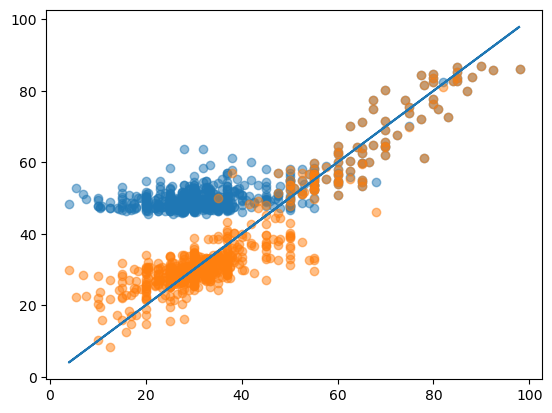

In [112]:
plt.scatter(y_test,pred_high,alpha=0.5)
plt.scatter(y_test,final_pred,alpha=0.5)
plt.plot(y_test,y_test)

In [80]:
pred_low

array([15.778329 , 13.94605  , 14.429052 , 14.156393 , 15.540267 ,
       15.704549 , 14.587393 , 13.6634655, 16.815077 , 15.791316 ,
       15.726174 , 16.612343 , 16.256845 , 14.802183 , 13.842666 ,
       16.402634 , 16.730846 , 14.283596 , 15.418967 , 16.199247 ,
       15.941873 , 16.345036 , 16.424107 , 15.442522 , 14.313032 ,
       15.216165 , 15.904765 , 13.776918 , 15.221253 , 14.773303 ,
       16.509596 , 15.912707 , 13.962868 , 16.310196 , 12.563131 ,
       14.922452 , 15.992714 , 14.16537  , 15.599311 , 14.226946 ,
       14.089563 , 14.919632 , 15.144623 , 10.464773 , 15.49827  ,
       13.244948 , 15.511407 , 16.022974 , 14.616045 , 15.006017 ,
       15.344453 , 12.746524 , 16.054106 , 13.041588 , 17.3043   ,
       15.355485 , 12.969991 , 13.675922 , 15.406056 , 15.659737 ,
       15.121353 , 13.588752 , 14.693066 , 14.009751 , 14.986392 ,
       15.778777 , 14.792968 , 15.210497 , 16.249928 , 15.85888  ,
       16.035227 , 14.486382 , 13.029903 , 15.8266325, 15.4496

In [81]:
y_test

tensor([[50.0000],
        [33.5000],
        [10.5000],
        [33.5000],
        [27.5000],
        [28.0000],
        [30.0000],
        [24.0000],
        [33.5000],
        [48.0000],
        [60.0000],
        [85.0000],
        [29.0000],
        [35.0000],
        [32.0000],
        [50.0000],
        [20.0000],
        [32.5000],
        [26.5000],
        [27.7500],
        [38.5000],
        [29.0000],
        [30.0000],
        [30.0000],
        [30.0000],
        [25.5000],
        [50.0000],
        [33.5000],
        [28.0000],
        [32.5000],
        [77.5000],
        [70.0000],
        [25.0000],
        [25.0000],
        [40.0000],
        [15.0000],
        [30.0000],
        [35.0000],
        [30.0000],
        [37.0000],
        [55.0000],
        [29.0000],
        [37.0000],
        [30.0000],
        [45.0000],
        [30.0000],
        [37.5000],
        [29.0000],
        [33.5000],
        [55.0000],
        [30.0000],
        [27.5000],
        [25.

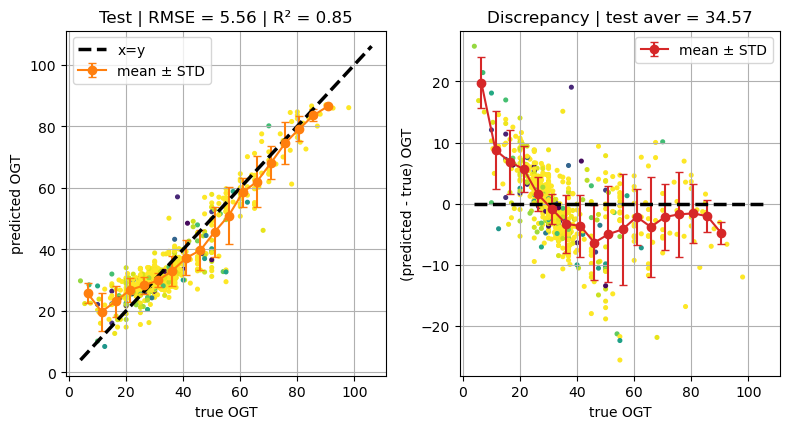

In [102]:
plt.figure(figsize=(8, 8))

# num_bins = 20
# min_temp = min(y_true_cv.squeeze())
# max_temp = max(y_true_cv.squeeze())

# Cross-Validation: prediction vs actual
plt.subplot(2, 2, 1) 
plt.scatter(y_test, final_pred, marker='o', alpha = 1, c = mx_prob, s=7)
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.squeeze(), final_pred, num_bins)
rmse_test = np.sqrt(mean_squared_error(y_test.squeeze(), final_pred))
r2_test = r2_score(y_test.squeeze(), final_pred)
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:orange', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[min_temp,max_temp], c = "black", label = "x=y", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("predicted OGT")
plt.title(f"Test | RMSE = {rmse_test:.2f} | R² = {r2_test:.2f}")
plt.legend()
plt.grid(True)

# Diff for full signal  
plt.subplot(2, 2, 2) 
y_test = y_test.cpu()
diff = [final_pred[i] - y_test[i] for i in range(len(final_pred))]
bin_centers, mean_diff, std_diff = calculate_aver_std(y_test.squeeze(), np.array([x.item() for x in diff]), num_bins)
plt.scatter(y_test.cpu(), diff, marker='o', alpha = 1, c = mx_prob, s=7, facecolor='none')    
plt.errorbar(bin_centers, mean_diff, yerr=std_diff, fmt='o-', color='tab:red', capsize=3, label='mean ± STD')
plt.plot([min_temp,max_temp],[0,0], c = "black", linestyle='--', linewidth=2.5) 
plt.xlabel("true OGT")
plt.ylabel("(predicted - true) OGT")
plt.title(f"Discrepancy | test aver = {mean_test:.2f}")
plt.legend()
plt.grid(True)
#plt.colorbar()



# Display the plots
plt.tight_layout()  
#plt.savefig(f"{OUTPUT_DIRECTORY}/baseline_cv_test_accuracy_all_feat.pdf", format="pdf")
plt.show()

In [95]:
range_labels_test

label_to_int = {'low': 0, 'mid': 1, 'high': 2}

# Vectorized conversion
encoded_labels = np.vectorize(label_to_int.get)(range_labels_test)
gate_probs


mx_prob = [max(g) for g in gate_probs]
min(mx_prob)

0.5057183736760782

Top 20 important features:
K02493: 0.0531
K19091: 0.0281
K00331: 0.0262
K06941: 0.0223
K06970: 0.0200
K07146: 0.0170
K00800: 0.0158
K03654: 0.0146
K00282: 0.0125
K06158: 0.0124
K14540: 0.0112
K07443: 0.0093
K07232: 0.0082
K06416: 0.0082
K06001: 0.0073
K22468: 0.0065
K07343: 0.0065
K06390: 0.0058
K03426: 0.0057
K07032: 0.0054


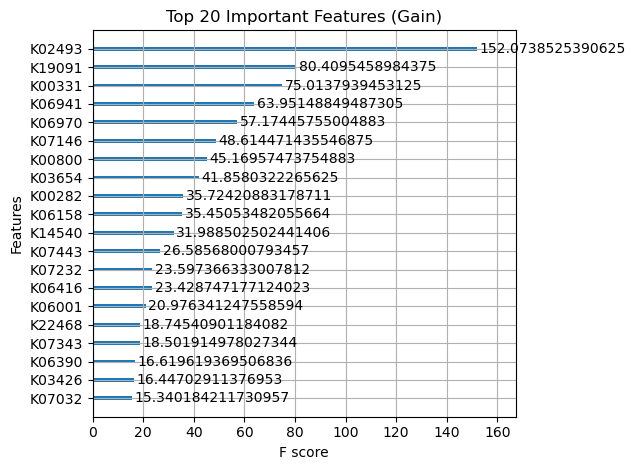

In [104]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Get feature importances from trained model
importances = gating_model.feature_importances_

# Use your actual column names
feature_names = X_column_names  # Make sure it's a list of strings

# Pair and sort
feature_importance_list = sorted(zip(feature_names, importances), key=lambda x: -x[1])

# Print top features
print("Top 20 important features:")
for feature, score in feature_importance_list[:20]:
    print(f"{feature}: {score:.4f}")

booster = gating_model.get_booster()

# Assign actual feature names
booster.feature_names = list(X_column_names)

# Plot
xgb.plot_importance(gating_model, max_num_features=20, importance_type='gain')
plt.title("Top 20 Important Features (Gain)")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Use held-out validation data if possible
y_val_labels = label_ogt_range(y_val)  # true labels
y_val_ids = le.transform(y_val_labels)

# Predict gating model outputs
gate_preds = gating_model.predict(X_val)

# Evaluate classification accuracy
print(classification_report(y_val_ids, gate_preds, target_names=le.classes_))



import pandas as pd

# Visualize softmax output for a few samples
gate_df = pd.DataFrame(gate_probs, columns=le.classes_)
print(gate_df.head())

# Optional: plot histogram of max probabilities (confidence)
import numpy as np
import matplotlib.pyplot as plt

confidences = gate_probs.max(axis=1)
plt.hist(confidences, bins=30)
plt.title("Gating Model Confidence")
plt.xlabel("Max Softmax Probability")
plt.ylabel("Num Samples")
plt.show()

# Compare where gate_preds match the true OGT label
correct_mask = (gate_preds == y_val_ids)

# Final prediction from mixture
final_pred_val = (
    gate_probs[:, id_low]  * model_low.predict(X_val) +
    gate_probs[:, id_mid]  * model_mid.predict(X_val) +
    gate_probs[:, id_high] * model_high.predict(X_val)
)

# RMSE split by gating correctness
from sklearn.metrics import mean_squared_error

rmse_correct = mean_squared_error(y_val[correct_mask], final_pred_val[correct_mask], squared=False)
rmse_wrong   = mean_squared_error(y_val[~correct_mask], final_pred_val[~correct_mask], squared=False)

print(f"RMSE (correctly gated): {rmse_correct:.2f}")
print(f"RMSE (wrongly gated):   {rmse_wrong:.2f}")